In [1]:
import pandas as pd 
import sklearn as sk
import numpy as np
from sklearn import metrics as met
import seaborn as sns 
from matplotlib import pyplot
import random
import pandas_datareader as web
from pandas_datareader import data as pdr
import yfinance as yfin
import pandas as pd
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [2]:
"""
stock_names are all the stocks we want to capture, keep them in lists together based on same stock type
"""
stock_names = [['aapl', 'msft', 'goog', 'amzn', 'tsla', 'fb', 'pltr', 'twtr', 'orcl', 'nvda'],
          ['voo', 'spy', 'vde', 'cibr', 'ivv', 'vcsh', 'spdn', 'fqal', 'ftec'],
          ['gold', 'xon', 'rio', 'vale', 'scco', 'lyb', 'btg', 'eva', 'bhp', 'nem'],
          ['btc-usd', 'eth-usd', 'sol-usd', 'matic-usd', 'avax-usd', 'cro-usd', 'atom-usd', 'uni-usd'],
          ['ups', 'unp', 'cni', 'csx', 'nsc', 'fdx', 'ryaay', 'aal', 'ksu'],
          ['jnj', 'pfe', 'abbv', 'abt', 'cvs', 'bmy', 'ci', 'mrna', 'hca'],
          ['vz', 'cmcsa', 't', 'tmus', 'abnb', 'vod', 'zm', 'rblx', 'chtr', 'rci'],
          ['c', 'bac', 'mtb', 'lyg', 'frc', 'gs', 'bbva', 'wfc', 'sivb', 'ewbc']]
allstocktypes = ['tech','etf','commodities','crypto','transportation','healthcare','communications','banks']
# removed = 'link-usd': crypto, 'unh': healthcare, , 'gld': etf, 'ual':transportation, 'doge-usd':crypto

In [3]:
def map_name_to_type(stocks: list,types: list) -> dict: 
    """
    Creates a map of all the stock names and their stock type, this will be useful for plotting later
    Args:
        stocks: The stocks to be mapped, this should be a list of lists where each embedded list is grouped by stock type (list)
        types: The stock types to be mapped, will be mapped in the same order they appear (list)
    Returns:
        dict: The map of stocks and stock types
    """
    mapped_names = {}
    for ix,stock_list in enumerate(stocks):
        for stock in stock_list:
            mapped_names.update({stock.upper():types[ix]})
            
    return(mapped_names)

stock_map = map_name_to_type(stock_names,allstocktypes)

In [4]:
#Building compiling function 

def grabstocks(stocktypes: list, stock_list: list) -> pd.DataFrame:
    """
    Uses yahoo finance to grab to stock data
    grabs all the columns for all the stocks in stock_names
    returns a concatinated dataframe of all the stocks across available weeks
    Args:
        stock_types: The stock types to be mapped, will be mapped in the same order they appear (list)
        stock_list: The stocks to be fetched, list of lists where each embedded list is grouped by stock type (list)
    Returns:
        pandas: Dataframe of all the columns from yahoo finance for each stock is stock_list, labeled with name and type
    """
    
    #created stocktypes for testing reasons
    
    # Initialize dict that will have all stocks and its type 
    
    stockdicts = {}
    fullstockdata = pd.DataFrame(columns = ['High','Low','Open','Close','Volume','Adj Close','Stock Name','Stock Type'])
    
    for ix,stocktype in enumerate(stock_list):
#         n = int(input("Enter number of "+str(stocktype)+" stocks(Type 0 for no stocks in sector): "))
#         stockls = list(map(str,input("\nEnter "+str(stocktype)+" stock symbols separated by spaces: ").strip().split()))[:n]
#         print(stockls)
        for stock in stocktype:
            try:
                stockdata = pdr.get_data_yahoo(str(stock.upper()), start=datetime(2018,2,8), end=datetime(2022,3, 10))
                stockdata['Stock Name'] = stock.upper()
                stockdata['Stock Type'] = stocktypes[ix]
                
                fullstockdata = pd.concat([fullstockdata,stockdata])
            except:
                print("Could not gather data on "+str(stock.upper()))
                pass
    return(fullstockdata)

stocks=grabstocks(stocktypes=allstocktypes, stock_list=stock_names).reset_index()
stocks.head()

Could not gather data on XON
Could not gather data on KSU


,index,High,Low,Open,Close,Volume,Adj Close,Stock Name,Stock Type
0,2018-02-08,40.250000,38.757500,40.072498,38.787498,217562000.0,37.049881,AAPL,tech
1,2018-02-09,39.472500,37.560001,39.267502,39.102501,282690400.0,37.503052,AAPL,tech
2,2018-02-12,40.972500,39.377499,39.625000,40.677502,243278000.0,39.013630,AAPL,tech
3,2018-02-13,41.187500,40.412498,40.487499,41.084999,130196800.0,39.404457,AAPL,tech
4,2018-02-14,41.884998,40.720001,40.759998,41.842499,162579600.0,40.130978,AAPL,tech


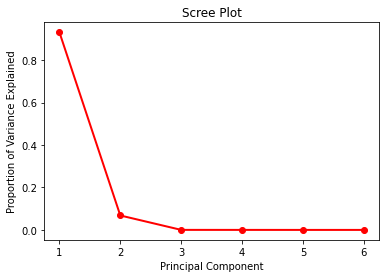

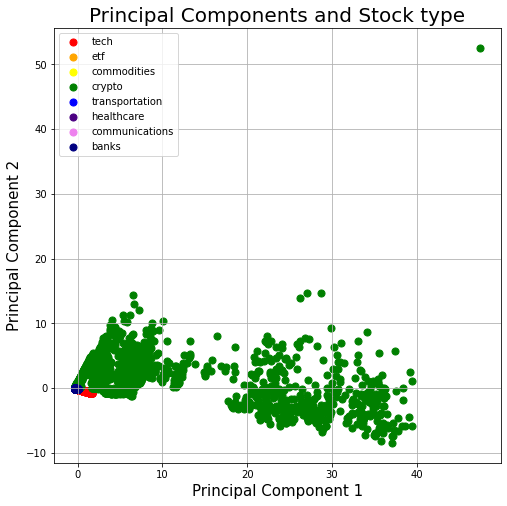

In [5]:
# Building PCA

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# adjust features being used here. I used all features available initially
xvars = ['High','Low','Open','Close','Volume','Adj Close']
yvars=['Stock Type']

x = stocks.loc[:,xvars]
x = StandardScaler().fit_transform(x)

y = stocks.loc[:,yvars]

# Choose principal components that are responsile for at least 95% of the variance in the data
pca = PCA()
principalcomponents = pca.fit_transform(x)
# create pcs dataframe with all pcs and y variable(will reduce dimensionality of pcswithy later on)
pcs = pd.DataFrame(data = principalcomponents)

columnnames = []
for i,column in enumerate(pcs.columns):
    columnnames.append('Principal Component '+str(i+1))
pcs.columns = columnnames

pcs = pcs.reset_index(drop=True)
y = y.reset_index(drop=True)
pcswithy = pd.concat([pcs, y], axis = 1)

#Screeplot of principal components

import matplotlib.pyplot as plt

pcvalues = np.arange(pca.n_components_) + 1
plt.plot(pcvalues, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

#Scatter plot of First 2 Principal components on stocktype

allstocktypes = ['tech','etf','commodities','crypto','transportation','healthcare','communications','banks']

#number_of_colors = len(allstocktypes)
#color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(number_of_colors)]

color=['red','orange','yellow','green','blue','indigo','violet','navy']

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Principal Components and Stock type', fontsize = 20)

#Adjust x and y limits for better looking graph
#ax.set_xlim([-2.5, 10])
#ax.set_ylim([-2.5, 2.5])

for stocktype, color in zip(allstocktypes,color):
    indicesToKeep = pcswithy['Stock Type'] == stocktype
    ax.scatter(pcswithy.loc[indicesToKeep, 'Principal Component 1']
               , pcswithy.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(allstocktypes)
ax.grid()



In [6]:

"""Can use either of the following methods(or both):
1: Choose principal components responsible for at least 95% of variance in data
2. Find PCS that have eigenvalue greater than 1 and use those PCS"""


pcs = pd.DataFrame(data = principalcomponents)
columnnames = []
for i,column in enumerate(pcs.columns):
    columnnames.append('Principal Component '+str(i))
pcs.columns = columnnames


#Find principal components that have eigenvalue greater than 1. 

explained_var = {}
eigenvalues = list(pca.explained_variance_)
pcstokeep = []

for i in eigenvalues:
    if i<1:
        eigenvalues.remove(i)

for i,var in enumerate(eigenvalues):
    name = 'Principal Component '+str(i+1)
    explained_var.update({name:var})
    pcstokeep.append(name)
    
print(explained_var) 


# Add y value to principal component data frame 

pcs = pcs.reset_index(drop=True)
y = y.reset_index(drop=True)
pcswithy = pd.concat([pcs[pcstokeep], y], axis = 1)

# """
# Only the first Principal component has an eignvalue over 1(PC 2 has a very small eignevalue). Since I fit on all
# the features as well as us having a lot of data there are probably some overfitting issues here. Play around with 
# the features being used for the PCA. Will add a loading plot for better analysis. 

# Also found that we can use the PCA to make our other models run quicker so we can probably use this PCA in a 
# pipeline once we have decided on features to use. Here is a link for more info:

# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
# """


{'Principal Component 1': 5.589961954992948, 'Principal Component 2': 0.001077805098875214, 'Principal Component 3': 0.0001021461407889016}


# PCA with just Close Values

In [7]:
"""
We need to remove weekends since only the cryptos can trade on weekends
"""

stocks['dow'] = stocks['index'].dt.strftime("%A") 
stocks_updated = stocks.loc[(stocks['dow'] != 'Saturday') & (stocks['dow'] != 'Sunday')]

In [8]:
"""
Keep only the Close values for each stock
We pivot the data so each stock's close value is a column
"""

stocks_close = stocks_updated[['index','Close','Stock Name']]
stocks_close = stocks_close.pivot(index = 'index', columns = 'Stock Name', values = 'Close')
stocks_close

Stock Name,AAL,AAPL,ABBV,ABNB,ABT,AMZN,ATOM-USD,AVAX-USD,BAC,BBVA,...,UNP,UPS,VALE,VCSH,VDE,VOD,VOO,VZ,WFC,ZM
index,,,,,,,,,,,,,,,,,,,,,
2018-02-08,48.599998,38.787498,108.480003,NaN,56.270000,1350.500000,NaN,NaN,29.740000,8.61,...,124.860001,109.279999,12.360000,78.779999,90.930000,28.400000,236.789993,49.040001,55.400002,NaN
2018-02-09,48.360001,39.102501,111.300003,NaN,57.169998,1339.599976,NaN,NaN,30.330000,8.61,...,127.279999,106.389999,12.910000,78.739998,90.800003,28.540001,240.440002,49.880001,56.130001,NaN
2018-02-12,50.090000,40.677502,111.930000,NaN,57.410000,1386.229980,NaN,NaN,31.120001,8.75,...,128.639999,106.309998,13.070000,78.699997,92.440002,28.450001,243.740005,50.110001,56.500000,NaN
2018-02-13,50.869999,41.084999,111.860001,NaN,57.639999,1414.510010,NaN,NaN,31.180000,8.67,...,128.300003,107.559998,13.270000,78.650002,92.029999,28.320000,244.559998,50.080002,58.000000,NaN
2018-02-14,51.070000,41.842499,113.080002,NaN,58.279999,1451.050049,NaN,NaN,32.000000,8.80,...,133.190002,106.599998,14.000000,78.489998,93.540001,28.469999,247.759995,49.509998,59.549999,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-07,12.840000,159.300003,149.449997,131.589996,118.860001,2749.060059,28.409777,71.880539,38.340000,4.80,...,261.459991,201.179993,20.600000,78.949997,106.379997,15.790000,385.609985,54.680000,45.810001,107.879997
2022-03-08,13.510000,157.440002,147.149994,142.130005,116.110001,2720.290039,27.845692,72.918358,38.590000,5.16,...,253.470001,203.410004,19.820000,78.699997,107.459999,15.590000,382.700012,53.250000,46.459999,108.489998
2022-03-09,14.300000,162.949997,148.839996,148.309998,118.389999,2785.580078,30.100052,77.716049,41.040001,5.53,...,253.669998,206.779999,18.719999,78.709999,104.559998,16.040001,392.899994,53.080002,49.160000,109.080002


In [9]:
"""
If the stock didn't start trading until recently, it will have many weeks with NA values
We want to remove these
"""

stocks_not_new = stocks_close.loc[:, stocks_close.isna().sum() < 50]
stocks_not_new.dropna(inplace = True)
stocks_not_new

<ipython-input-9-2998806af412>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks_not_new.dropna(inplace = True)


Stock Name,AAL,AAPL,ABBV,ABT,AMZN,BAC,BBVA,BHP,BMY,BTC-USD,...,TWTR,UNP,UPS,VALE,VCSH,VDE,VOD,VOO,VZ,WFC
index,,,,,,,,,,,,,,,,,,,,,
2018-02-08,48.599998,38.787498,108.480003,56.270000,1350.500000,29.740000,8.61,44.759998,62.689999,8265.589844,...,30.180000,124.860001,109.279999,12.360000,78.779999,90.930000,28.400000,236.789993,49.040001,55.400002
2018-02-09,48.360001,39.102501,111.300003,57.169998,1339.599976,30.330000,8.61,45.759998,62.700001,8736.980469,...,31.510000,127.279999,106.389999,12.910000,78.739998,90.800003,28.540001,240.440002,49.880001,56.130001
2018-02-12,50.090000,40.677502,111.930000,57.410000,1386.229980,31.120001,8.75,46.799999,63.160000,8926.570312,...,30.950001,128.639999,106.309998,13.070000,78.699997,92.440002,28.450001,243.740005,50.110001,56.500000
2018-02-13,50.869999,41.084999,111.860001,57.639999,1414.510010,31.180000,8.67,47.740002,63.869999,8598.309570,...,33.439999,128.300003,107.559998,13.270000,78.650002,92.029999,28.320000,244.559998,50.080002,58.000000
2018-02-14,51.070000,41.842499,113.080002,58.279999,1451.050049,32.000000,8.80,49.279999,65.349998,9494.629883,...,33.750000,133.190002,106.599998,14.000000,78.489998,93.540001,28.469999,247.759995,49.509998,59.549999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,14.590000,163.169998,150.559998,121.410004,2912.820068,40.950001,5.29,73.120003,69.360001,39137.605469,...,33.389999,264.630005,210.389999,20.150000,79.320000,104.730003,16.400000,397.339996,55.110001,48.790001
2022-03-07,12.840000,159.300003,149.449997,118.860001,2749.060059,38.340000,4.80,72.400002,68.769997,38062.039062,...,32.419998,261.459991,201.179993,20.600000,78.949997,106.379997,15.790000,385.609985,54.680000,45.810001
2022-03-08,13.510000,157.440002,147.149994,116.110001,2720.290039,38.590000,5.16,69.570000,67.739998,38737.269531,...,32.680000,253.470001,203.410004,19.820000,78.699997,107.459999,15.590000,382.700012,53.250000,46.459999


In [10]:
stocks_prep = stocks_not_new.reset_index()
stocks_prep

Stock Name,index,AAL,AAPL,ABBV,ABT,AMZN,BAC,BBVA,BHP,BMY,...,TWTR,UNP,UPS,VALE,VCSH,VDE,VOD,VOO,VZ,WFC
0,2018-02-08,48.599998,38.787498,108.480003,56.270000,1350.500000,29.740000,8.61,44.759998,62.689999,...,30.180000,124.860001,109.279999,12.360000,78.779999,90.930000,28.400000,236.789993,49.040001,55.400002
1,2018-02-09,48.360001,39.102501,111.300003,57.169998,1339.599976,30.330000,8.61,45.759998,62.700001,...,31.510000,127.279999,106.389999,12.910000,78.739998,90.800003,28.540001,240.440002,49.880001,56.130001
2,2018-02-12,50.090000,40.677502,111.930000,57.410000,1386.229980,31.120001,8.75,46.799999,63.160000,...,30.950001,128.639999,106.309998,13.070000,78.699997,92.440002,28.450001,243.740005,50.110001,56.500000
3,2018-02-13,50.869999,41.084999,111.860001,57.639999,1414.510010,31.180000,8.67,47.740002,63.869999,...,33.439999,128.300003,107.559998,13.270000,78.650002,92.029999,28.320000,244.559998,50.080002,58.000000
4,2018-02-14,51.070000,41.842499,113.080002,58.279999,1451.050049,32.000000,8.80,49.279999,65.349998,...,33.750000,133.190002,106.599998,14.000000,78.489998,93.540001,28.469999,247.759995,49.509998,59.549999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,2022-03-04,14.590000,163.169998,150.559998,121.410004,2912.820068,40.950001,5.29,73.120003,69.360001,...,33.389999,264.630005,210.389999,20.150000,79.320000,104.730003,16.400000,397.339996,55.110001,48.790001
1025,2022-03-07,12.840000,159.300003,149.449997,118.860001,2749.060059,38.340000,4.80,72.400002,68.769997,...,32.419998,261.459991,201.179993,20.600000,78.949997,106.379997,15.790000,385.609985,54.680000,45.810001
1026,2022-03-08,13.510000,157.440002,147.149994,116.110001,2720.290039,38.590000,5.16,69.570000,67.739998,...,32.680000,253.470001,203.410004,19.820000,78.699997,107.459999,15.590000,382.700012,53.250000,46.459999
1027,2022-03-09,14.300000,162.949997,148.839996,118.389999,2785.580078,41.040001,5.53,69.839996,68.129997,...,34.369999,253.669998,206.779999,18.719999,78.709999,104.559998,16.040001,392.899994,53.080002,49.160000


LTSM Model 

In [11]:
#Resetting the features. 

stocks_shift = stocks_prep.drop('index', axis = 1)


def df_shift(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for c in df.columns:
        if c == target:
            new[c] = df[target]
        else:
            new[c] = df[c].shift(periods=lag)
    return  pd.DataFrame(data=new)

target_variable_user= 'AAPL'
lag_val=1


stocks_shift= df_shift(stocks_shift, target_variable_user, lag=lag_val)

In [12]:
print(stocks_prep.tail())
print(stocks_shift.tail())

Stock Name      index    AAL        AAPL        ABBV         ABT         AMZN  \
1024       2022-03-04  14.59  163.169998  150.559998  121.410004  2912.820068   
1025       2022-03-07  12.84  159.300003  149.449997  118.860001  2749.060059   
1026       2022-03-08  13.51  157.440002  147.149994  116.110001  2720.290039   
1027       2022-03-09  14.30  162.949997  148.839996  118.389999  2785.580078   
1028       2022-03-10  14.20  158.520004  149.169998  117.000000  2936.350098   

Stock Name        BAC  BBVA        BHP        BMY  ...       TWTR         UNP  \
1024        40.950001  5.29  73.120003  69.360001  ...  33.389999  264.630005   
1025        38.340000  4.80  72.400002  68.769997  ...  32.419998  261.459991   
1026        38.590000  5.16  69.570000  67.739998  ...  32.680000  253.470001   
1027        41.040001  5.53  69.839996  68.129997  ...  34.369999  253.669998   
1028        40.669998  5.51  71.209999  68.419998  ...  34.119999  259.649994   

Stock Name         UPS    

In [13]:
#Resetting the features. 

scaled = StandardScaler().fit_transform(stocks_shift)

sdf = pd.DataFrame(data=scaled, index= stocks_prep['index'],columns=stocks_shift.columns)

sdf

sdf=sdf.dropna()

In [14]:
#Creating tain and test splits for our our ltsm model. 

sdf.shape

split_number= 800

train = sdf.iloc[:split_number, :]
test = sdf.iloc[split_number:, :]

train_X = train.drop(target_variable_user, axis = 1)
train_y= train[target_variable_user]
test_X = test.drop(target_variable_user, axis = 1)
test_y= test[target_variable_user]


train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


train_X.shape[1]

#pip install seq2seq-lstm



1

Epoch 1/200
14/14 - 2s - loss: 0.4677 - val_loss: 1.1434 - 2s/epoch - 112ms/step
Epoch 2/200
14/14 - 0s - loss: 0.2568 - val_loss: 0.7692 - 66ms/epoch - 5ms/step
Epoch 3/200
14/14 - 0s - loss: 0.1271 - val_loss: 0.5299 - 70ms/epoch - 5ms/step
Epoch 4/200
14/14 - 0s - loss: 0.1034 - val_loss: 0.6569 - 58ms/epoch - 4ms/step
Epoch 5/200
14/14 - 0s - loss: 0.0858 - val_loss: 0.7437 - 57ms/epoch - 4ms/step
Epoch 6/200
14/14 - 0s - loss: 0.1235 - val_loss: 0.5371 - 61ms/epoch - 4ms/step
Epoch 7/200
14/14 - 0s - loss: 0.1102 - val_loss: 0.7212 - 61ms/epoch - 4ms/step
Epoch 8/200
14/14 - 0s - loss: 0.1527 - val_loss: 0.5226 - 63ms/epoch - 4ms/step
Epoch 9/200
14/14 - 0s - loss: 0.1003 - val_loss: 0.6671 - 57ms/epoch - 4ms/step
Epoch 10/200
14/14 - 0s - loss: 0.1461 - val_loss: 0.5160 - 57ms/epoch - 4ms/step
Epoch 11/200
14/14 - 0s - loss: 0.0852 - val_loss: 0.6524 - 57ms/epoch - 4ms/step
Epoch 12/200
14/14 - 0s - loss: 0.1134 - val_loss: 0.5039 - 54ms/epoch - 4ms/step
Epoch 13/200
14/14 - 0s -

14/14 - 0s - loss: 0.0565 - val_loss: 0.2304 - 52ms/epoch - 4ms/step
Epoch 102/200
14/14 - 0s - loss: 0.0592 - val_loss: 0.2858 - 59ms/epoch - 4ms/step
Epoch 103/200
14/14 - 0s - loss: 0.0523 - val_loss: 0.2296 - 57ms/epoch - 4ms/step
Epoch 104/200
14/14 - 0s - loss: 0.0566 - val_loss: 0.2923 - 65ms/epoch - 5ms/step
Epoch 105/200
14/14 - 0s - loss: 0.0505 - val_loss: 0.2320 - 67ms/epoch - 5ms/step
Epoch 106/200
14/14 - 0s - loss: 0.0524 - val_loss: 0.2768 - 58ms/epoch - 4ms/step
Epoch 107/200
14/14 - 0s - loss: 0.0482 - val_loss: 0.2339 - 55ms/epoch - 4ms/step
Epoch 108/200
14/14 - 0s - loss: 0.0503 - val_loss: 0.2586 - 52ms/epoch - 4ms/step
Epoch 109/200
14/14 - 0s - loss: 0.0609 - val_loss: 0.2506 - 55ms/epoch - 4ms/step
Epoch 110/200
14/14 - 0s - loss: 0.0654 - val_loss: 0.2414 - 50ms/epoch - 4ms/step
Epoch 111/200
14/14 - 0s - loss: 0.0756 - val_loss: 0.2607 - 52ms/epoch - 4ms/step
Epoch 112/200
14/14 - 0s - loss: 0.0510 - val_loss: 0.2311 - 55ms/epoch - 4ms/step
Epoch 113/200
14/1

Epoch 200/200
14/14 - 0s - loss: 0.0520 - val_loss: 0.2470 - 58ms/epoch - 4ms/step


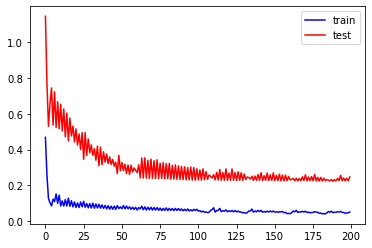

In [28]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Activation, Dense


model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=200, batch_size=60, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train',color='blue')
pyplot.plot(history.history['val_loss'], label='test',color='red')
pyplot.legend()
pyplot.show()